Framingham Dataset

In [30]:
%pip install numpy pandas seaborn matplotlib torch scikit-learn torch imblearn xgboost shap

     ------------------------------------- 544.4/544.4 kB 11.4 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 kB 4.3 MB/s eta 0:00:00
     ---------------------------------------- 2.8/2.8 MB 45.5 MB/s eta 0:00:00
     --------------------------------------- 30.3/30.3 MB 50.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

df = pd.read_csv("../raw_data/raw_Framingham/framingham.csv")
#check if the dataset is loaded
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [9]:
df.shape

(4240, 16)

In [10]:
columns=['male','age','education','currentSmoker','cigsPerDay','BPMeds','prevalentStroke','prevalentHyp','diabetes','totChol','sysBP','diaBP','BMI','heartRate','glucose','TenYearCHD']

  Initial Analysis

In [11]:
df.isnull().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [12]:
full_df = df.dropna()

In [13]:
full_df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [14]:
full_df.duplicated().sum()

np.int64(0)

Data Preprocessing

In [15]:
X=full_df.drop(columns=['TenYearCHD'])
y=full_df['TenYearCHD']

In [16]:
num_before = dict(Counter(y))

# Perform SMOTE
# Define Pipeline
over=SMOTE(sampling_strategy='auto')
under=RandomUnderSampler(sampling_strategy='auto')
steps=[("o",over),("u",under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
X_smote,y_smote=pipeline.fit_resample(X,y)

# The numbers after SMOTE
num_after=dict(Counter(y_smote))

In [17]:
print(num_before,num_after)

{0: 3101, 1: 557} {0: 3101, 1: 3101}


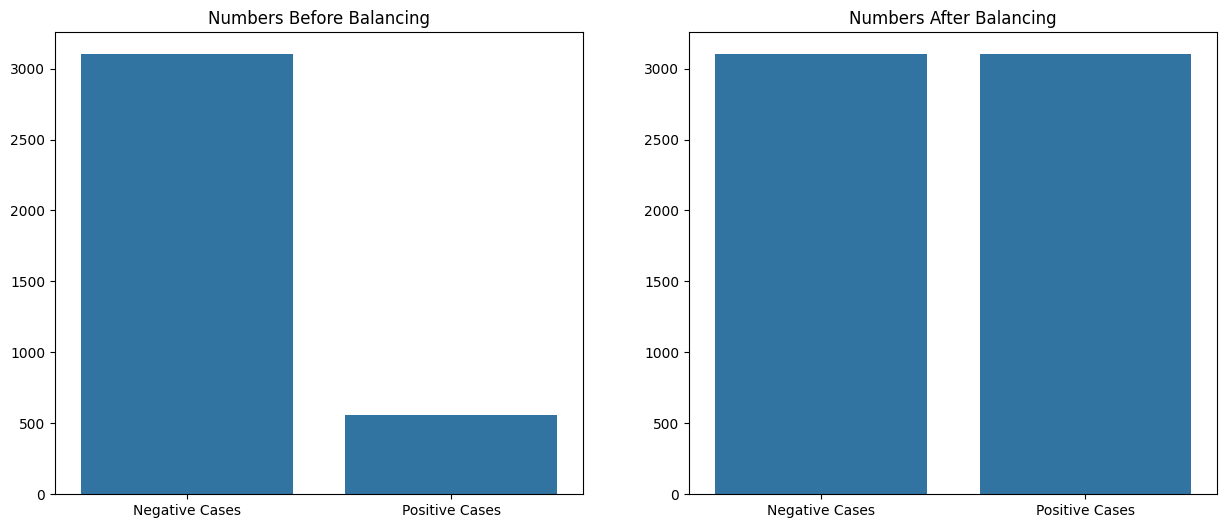

In [18]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x=labels, y=list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(x=labels, y=list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

In [19]:
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0,0


In [20]:
X_new = new_data.iloc[:, 0:15]
y_new= new_data.iloc[:,-1]
X_new.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0
5,0,43,2.0,0,0.0,0.0,0,1,0,228.0,180.0,110.0,30.30,77.0,99.0


In [21]:
X_train,X_test,y_train,y_test=train_test_split(X_new,y_new,test_size=0.2,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4961, 15)
(4961,)
(1241, 15)
(1241,)


In [22]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [23]:
X_train=pd.DataFrame(X_train_scaled,columns=columns[:-1])
X_test=pd.DataFrame(X_test_scaled,columns=columns[:-1])

In [24]:
X_train.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1.215230,-0.754425,2.171443,1.104394,0.871839,-0.237172,-0.058639,-0.724929,-0.183144,-0.318019,-0.741774,-0.756699,-0.183748,-0.503837,-0.604514
1,-0.822889,-1.476838,-0.955309,-0.905474,-0.794675,-0.237172,-0.058639,-0.724929,-0.183144,-0.295867,0.059813,0.363903,0.175133,1.691223,-0.801019
2,1.215230,-0.995229,0.086942,1.104394,2.538354,-0.237172,-0.058639,1.379445,-0.183144,-0.450934,1.198909,1.644591,1.285102,-0.064825,0.967532
3,-0.822889,-0.634023,1.026349,1.104394,0.871839,-0.237172,-0.058639,-0.724929,-0.183144,0.577118,-0.750099,-1.486045,0.583737,0.611603,-0.303292
4,1.215230,0.690401,0.965888,-0.905474,-0.794675,-0.237172,-0.058639,-0.724929,-0.183144,-0.629754,-0.043877,0.364887,0.399197,-1.218933,-0.345273


Random Forest

In [25]:
param_grid = {
    'n_estimators': [25, 30, 40, 50, 75, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [8, 9, 10, 11, 12],
    'criterion' :['gini', 'entropy']
}
randfor = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
randfor.fit(X_train, y_train)

print(randfor.best_params_)


{'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 200}


              precision    recall  f1-score   support

           0       0.90      0.87      0.89       642
           1       0.87      0.90      0.88       599

    accuracy                           0.88      1241
   macro avg       0.88      0.89      0.88      1241
weighted avg       0.89      0.88      0.88      1241



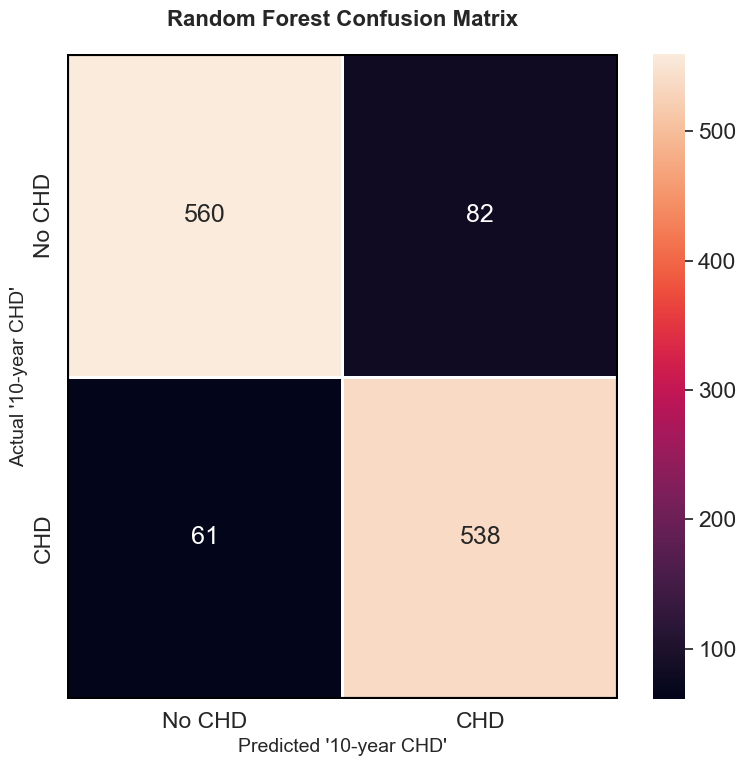

In [28]:
y_pred_randfor = randfor.predict(X_test)

print(classification_report(y_test, y_pred_randfor))

confusion_randfor = confusion_matrix(y_test, y_pred_randfor)

with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))

    class_labels = ["No CHD", "CHD"]
    sns.heatmap(confusion_randfor, annot=True, fmt="d", cmap='rocket', linewidths=2, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('Random Forest Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted '10-year CHD'", fontsize=14)
    ax.set_ylabel("Actual '10-year CHD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=confusion_randfor.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=confusion_randfor.shape[1], color='black', linewidth=3)

    # Improve layout
    plt.tight_layout()
    plt.show()


In [29]:
randfor_recall_score = recall_score(y_test, y_pred_randfor, labels=[1])
randfor_avg_recall_score = recall_score(y_test, y_pred_randfor, average="weighted")
randfor_avg_precision_score = precision_score(y_test, y_pred_randfor, average="weighted")
print(f"Random Forest Classifier Recall ('Average'): {randfor_avg_recall_score}")
print(f"Random Forest Classifier Precision ('Average'): {randfor_avg_precision_score}")

Random Forest Classifier Recall ('Average'): 0.8847703464947623
Random Forest Classifier Precision ('Average'): 0.8853461864806378


Using 4961 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


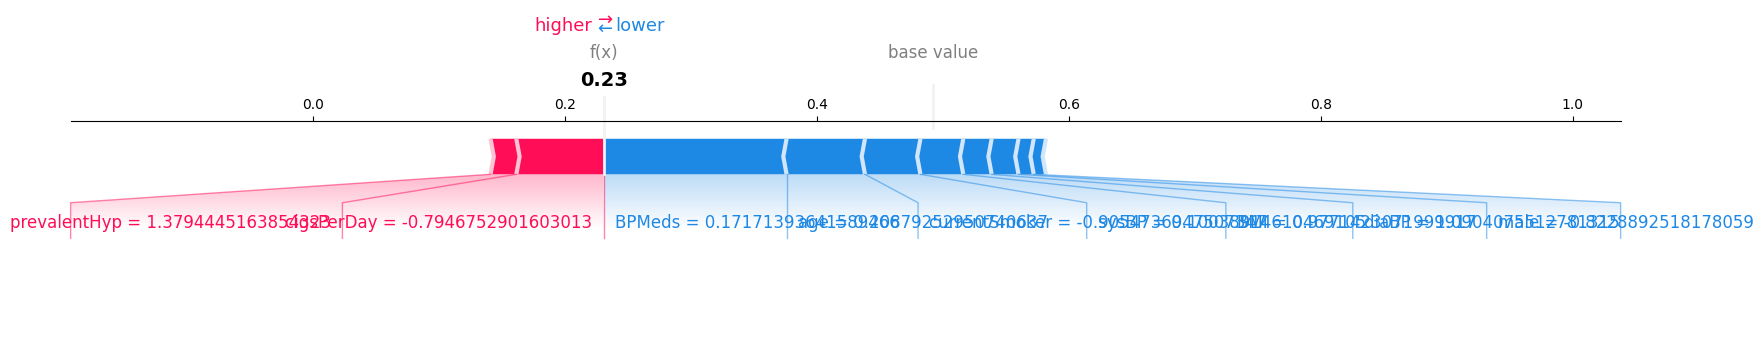

In [35]:
import shap

shap.initjs()
explainer_randfor = shap.KernelExplainer(randfor.best_estimator_.predict_proba, X_train)

shap_values = explainer_randfor.shap_values(X_test.iloc[0,:])
shap.plots.force(explainer_randfor.expected_value[0], shap_values[..., 0], X_test.iloc[0,:],matplotlib=True)

Logistic Regression

In [36]:
param_grid={
    'C':[0.001,0.01,0.1,1,10,100,1000],
    'penalty':['l1','l2'],
    'solver':['liblinear']
}
logistic_regression = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
logistic_regression.fit(X_train, y_train)

print(logistic_regression.best_params_)


{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}


              precision    recall  f1-score   support

           0       0.70      0.64      0.67       642
           1       0.64      0.70      0.67       599

    accuracy                           0.67      1241
   macro avg       0.67      0.67      0.67      1241
weighted avg       0.67      0.67      0.67      1241



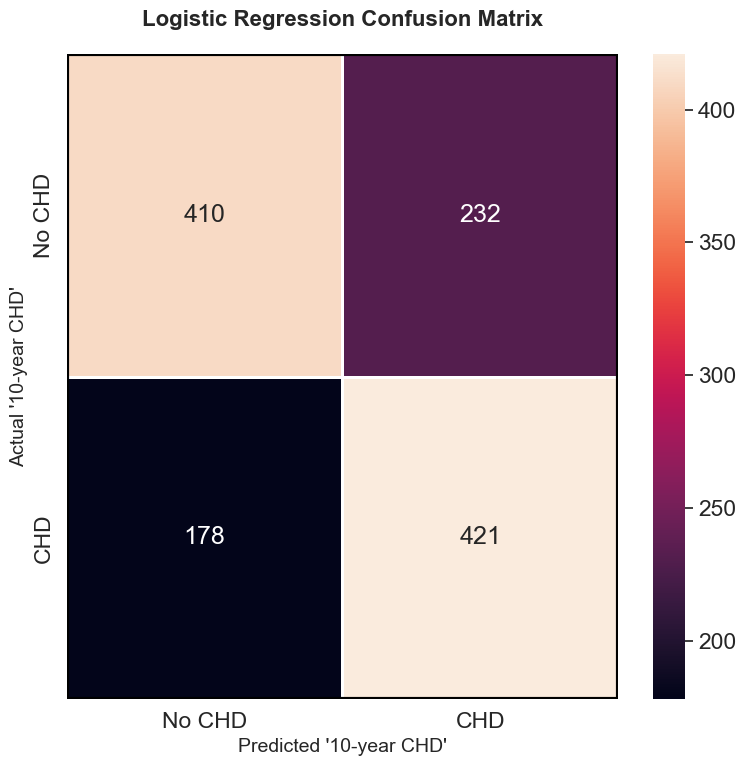

In [37]:
y_pred_logistic =logistic_regression.predict(X_test)

print(classification_report(y_test, y_pred_logistic))

confusion_logistic = confusion_matrix(y_test, y_pred_logistic)

with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))

    class_labels = ["No CHD", "CHD"]
    sns.heatmap(confusion_logistic, annot=True, fmt="d", cmap='rocket', linewidths=2, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('Logistic Regression Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted '10-year CHD'", fontsize=14)
    ax.set_ylabel("Actual '10-year CHD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=confusion_logistic.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=confusion_logistic.shape[1], color='black', linewidth=3)

    # Improve layout
    plt.tight_layout()
    plt.show()


In [38]:
logistic_recall_score = recall_score(y_test, y_pred_logistic, labels=[1])
logistic_avg_recall_score = recall_score(y_test, y_pred_logistic, average="weighted")
logistic_avg_precision_score = precision_score(y_test, y_pred_logistic, average="weighted")
print(f"Logistic Regression Recall ('Average'): {logistic_avg_recall_score}")
print(f"Logistic Regression Precision ('Average'): {logistic_avg_precision_score}")

Logistic Regression Recall ('Average'): 0.669621273166801
Logistic Regression Precision ('Average'): 0.6719084285626394


Using 4961 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


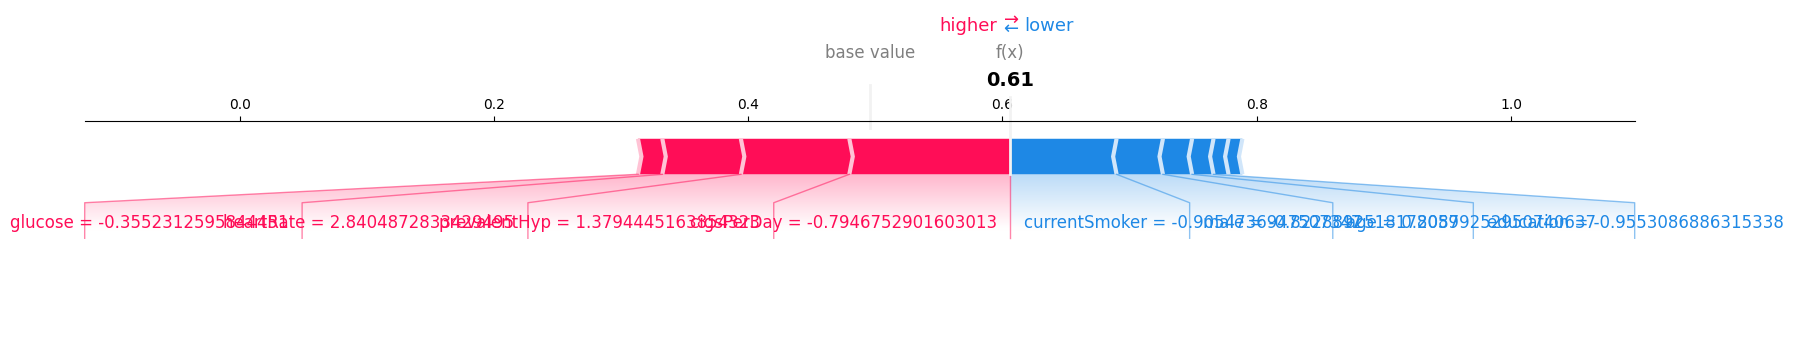

In [39]:
import shap

shap.initjs()
explainer_logistic = shap.KernelExplainer(logistic_regression.best_estimator_.predict_proba, X_train)

shap_values = explainer_logistic.shap_values(X_test.iloc[0,:])
shap.plots.force(explainer_logistic.expected_value[0], shap_values[..., 0], X_test.iloc[0,:],matplotlib=True)

XGBoost

In [43]:
param_grid={
    'n_estimators':[50,100,200],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5,7],
    'min_child_weight':[1,3,5],
    'subsample':[0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0]
}
xgboost = GridSearchCV(xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42), param_grid, cv=5)
xgboost.fit(X_train, y_train)
xgboost.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 200,
 'subsample': 1.0}

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       642
           1       0.92      0.87      0.89       599

    accuracy                           0.90      1241
   macro avg       0.90      0.90      0.90      1241
weighted avg       0.90      0.90      0.90      1241



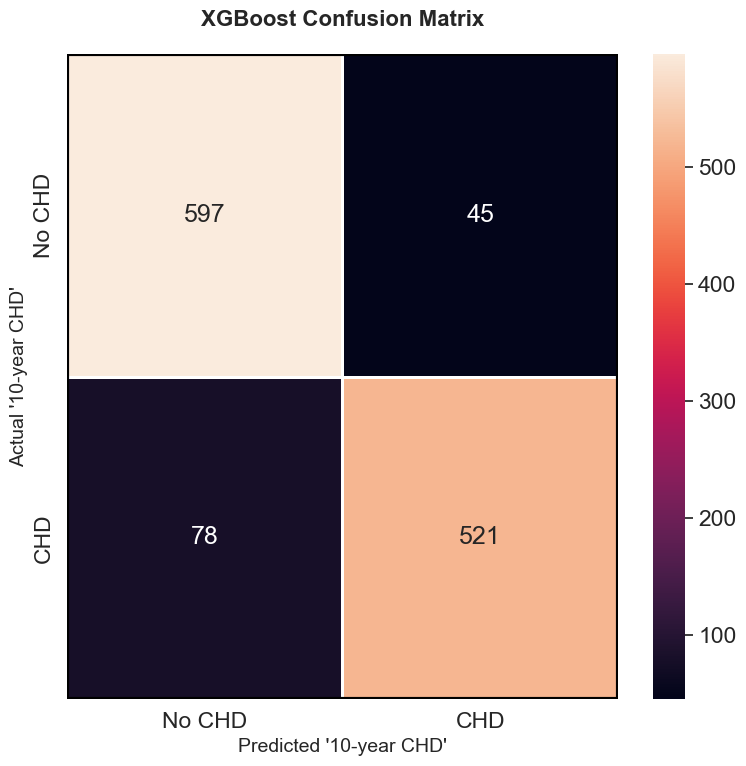

In [44]:
y_pred_xgboost =xgboost.predict(X_test)

print(classification_report(y_test, y_pred_xgboost))

confusion_xgboost = confusion_matrix(y_test, y_pred_xgboost)

with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))

    class_labels = ["No CHD", "CHD"]
    sns.heatmap(confusion_xgboost, annot=True, fmt="d", cmap='rocket', linewidths=2, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('XGBoost Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted '10-year CHD'", fontsize=14)
    ax.set_ylabel("Actual '10-year CHD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=confusion_xgboost.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=confusion_xgboost.shape[1], color='black', linewidth=3)

    # Improve layout
    plt.tight_layout()
    plt.show()

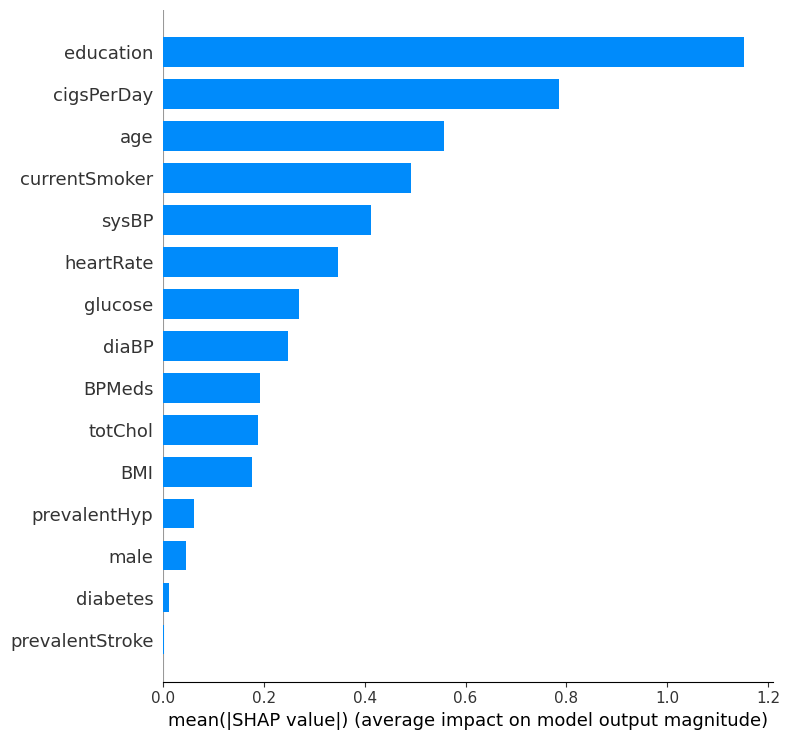

In [47]:
import shap

explainer = shap.TreeExplainer(xgboost.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Summary plot with readable names
shap.summary_plot(shap_values, X_test, plot_type="bar")

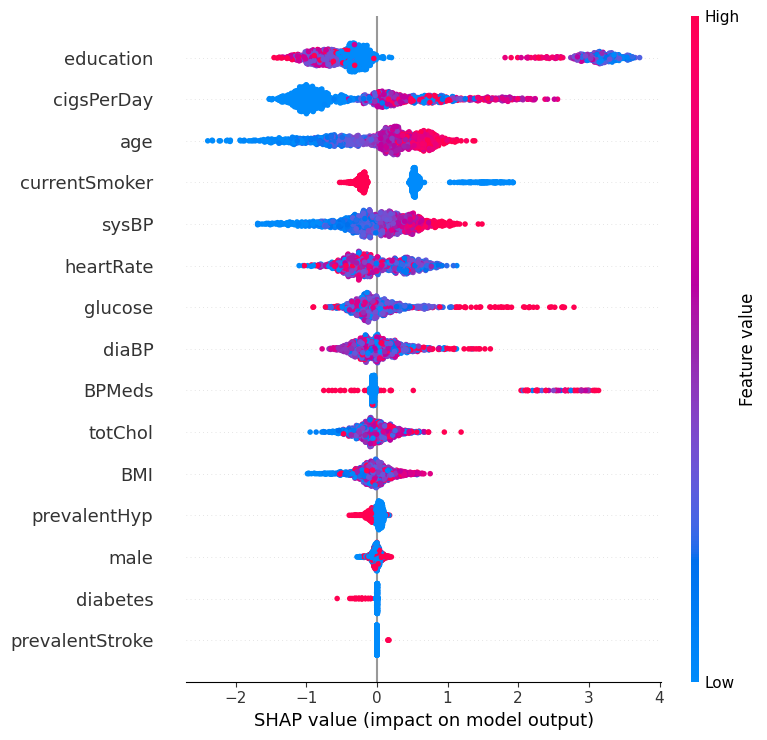

In [46]:
shap.summary_plot(shap_values, X_test)

In [48]:
xgboost_recall_score = recall_score(y_test, y_pred_xgboost, labels=[1])
xgboost_avg_recall_score = recall_score(y_test, y_pred_xgboost, average="weighted")
xgboost_avg_precision_score = precision_score(y_test, y_pred_xgboost, average="weighted")
print(f"XGBoost Recall ('Average'): {xgboost_avg_recall_score}")
print(f"XGBoost Precision ('Average'): {xgboost_avg_precision_score}")

XGBoost Recall ('Average'): 0.9008863819500403
XGBoost Precision ('Average'): 0.9018450108152074


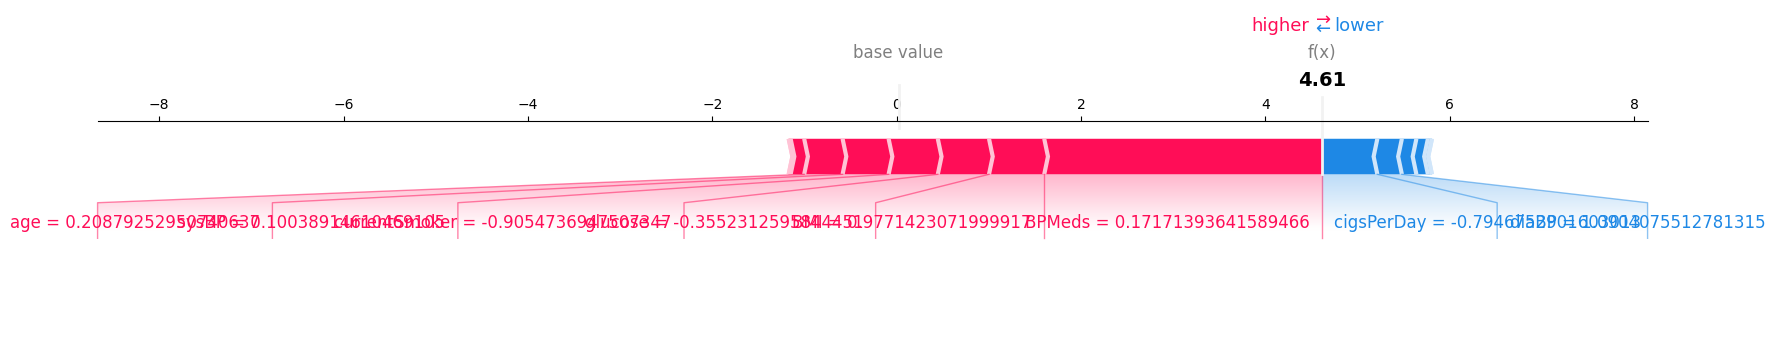

In [49]:
explainer = shap.Explainer(xgboost.best_estimator_)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# If SHAP values are an Explanation object, extract the values
if isinstance(shap_values, shap.Explanation):
    shap_values = shap_values.values

shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :], matplotlib=True)

Neural Networks


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

In [51]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [52]:
model = NeuralNetwork(X_train.shape[1]).to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [53]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 300
batch_size = 16
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/300], Loss: 0.6548
Epoch [20/300], Loss: 0.6210
Epoch [30/300], Loss: 0.5967
Epoch [40/300], Loss: 0.5798
Epoch [50/300], Loss: 0.5660
Epoch [60/300], Loss: 0.5537
Epoch [70/300], Loss: 0.5417
Epoch [80/300], Loss: 0.5293
Epoch [90/300], Loss: 0.5164
Epoch [100/300], Loss: 0.5026
Epoch [110/300], Loss: 0.4881
Epoch [120/300], Loss: 0.4729
Epoch [130/300], Loss: 0.4571
Epoch [140/300], Loss: 0.4407
Epoch [150/300], Loss: 0.4238
Epoch [160/300], Loss: 0.4063
Epoch [170/300], Loss: 0.3880
Epoch [180/300], Loss: 0.3694
Epoch [190/300], Loss: 0.3520
Epoch [200/300], Loss: 0.3360
Epoch [210/300], Loss: 0.3209
Epoch [220/300], Loss: 0.3063
Epoch [230/300], Loss: 0.2926
Epoch [240/300], Loss: 0.2817
Epoch [250/300], Loss: 0.2699
Epoch [260/300], Loss: 0.2607
Epoch [270/300], Loss: 0.2516
Epoch [280/300], Loss: 0.2428
Epoch [290/300], Loss: 0.2342
Epoch [300/300], Loss: 0.2262


In [54]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = (y_pred_test > 0.5).float()  # Convert probabilities to binary values (0 or 1)

# Convert predictions to numpy for evaluation
y_pred_np = y_pred_labels.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print("Test Set Accuracy:", accuracy)

nn_precision = precision_score(y_test_np, y_pred_np)
print("Test Set Precision:", nn_precision)

# Calculate recall
nn_recall = recall_score(y_test_np, y_pred_np)
print("Test Set Recall:", nn_recall)

nn_avg_precision = precision_score(y_test_np, y_pred_np, average="weighted")

# Calculate recall
nn_avg_recall = recall_score(y_test_np, y_pred_np, average="weighted")

Test Set Accuracy: 0.806607574536664
Test Set Precision: 0.7723823975720789
Test Set Recall: 0.8497495826377296


KNN


In [56]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # Number of nearest neighbors
    'weights': ['uniform', 'distance'],  # Weighting strategy
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Initialize and train KNN with GridSearchCV
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
knn_grid.fit(X_train, y_train)

# Best parameters
print("Best KNN Parameters:", knn_grid.best_params_)

Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


              precision    recall  f1-score   support

           0       0.94      0.69      0.79       642
           1       0.74      0.95      0.83       599

    accuracy                           0.82      1241
   macro avg       0.84      0.82      0.81      1241
weighted avg       0.84      0.82      0.81      1241



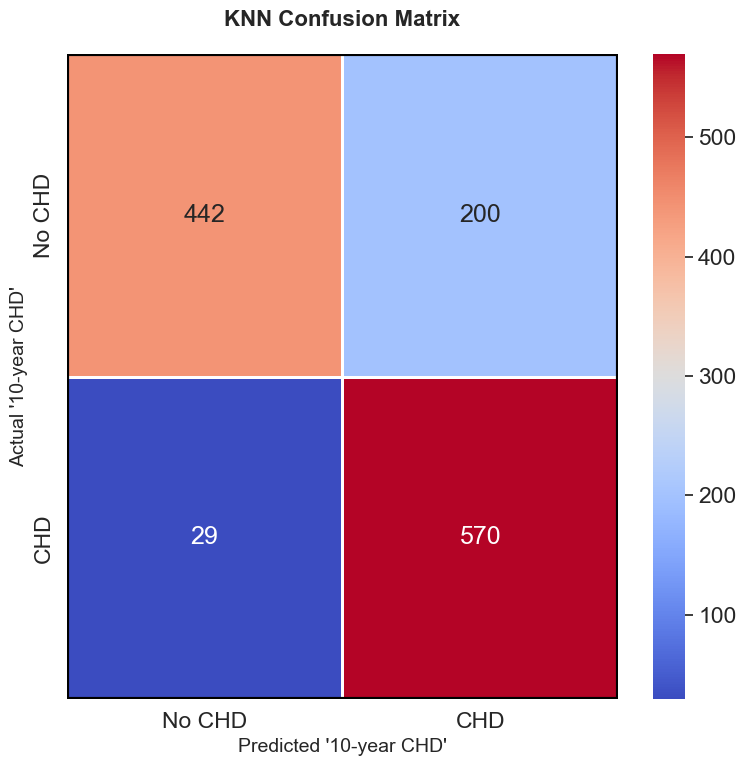

In [57]:
y_pred_knn =knn_grid.predict(X_test)

print(classification_report(y_test, y_pred_knn))

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)


# Confusion Matrix Visualization
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))
    class_labels = ["No CHD", "CHD"]
    sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap='coolwarm', linewidths=2,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('KNN Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted '10-year CHD'", fontsize=14)
    ax.set_ylabel("Actual '10-year CHD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=conf_matrix_knn.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=conf_matrix_knn.shape[1], color='black', linewidth=3)
    plt.tight_layout()
    plt.show()

In [58]:
knn_recall_score = recall_score(y_test, y_pred_knn, labels=[1])
knn_avg_recall_score = recall_score(y_test, y_pred_knn, average="weighted")
knn_avg_precision_score = precision_score(y_test, y_pred_knn, average="weighted")
print(f"KNN Recall ('Average'): {knn_avg_recall_score}")
print(f"KNN Precision ('Average'): {knn_avg_precision_score}")

KNN Recall ('Average'): 0.8154713940370669
KNN Precision ('Average'): 0.8427775358543129


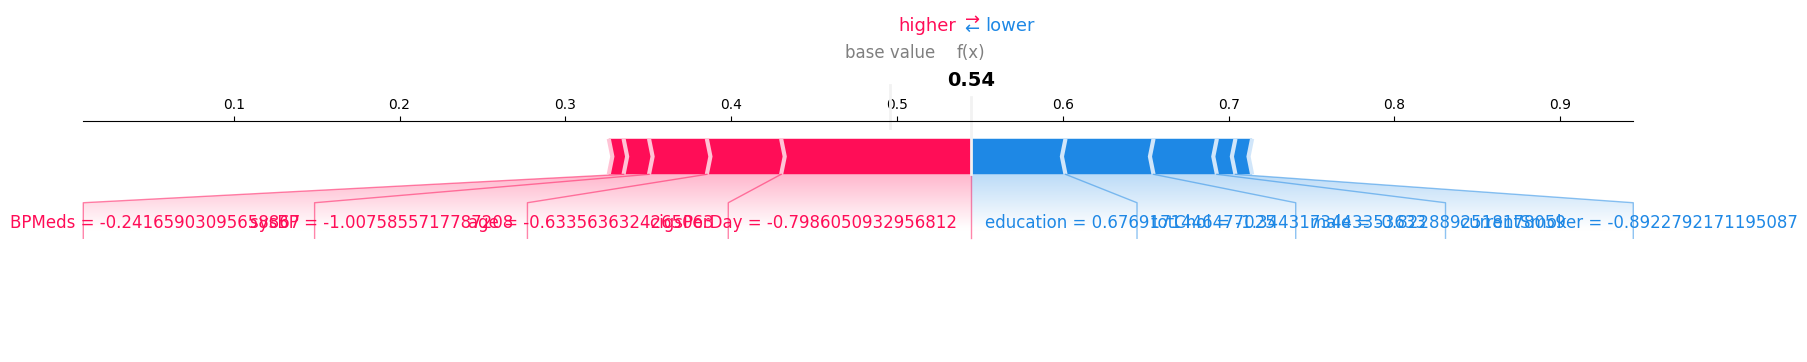

In [ ]:
import shap

shap.initjs()
explainer_knn = shap.KernelExplainer(knn_grid.best_estimator_.predict_proba, X_train)

shap_values = explainer_knn.shap_values(X_test.iloc[0, :])
shap.force_plot(explainer_knn.expected_value[0], shap_values[:, 0], X_test.iloc[0, :], matplotlib=True)

C:\Users\Shreyas Raman\AppData\Local\Temp\ipykernel_41976\3101633249.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=30, horizontalalignment='right', rotation_mode='anchor')


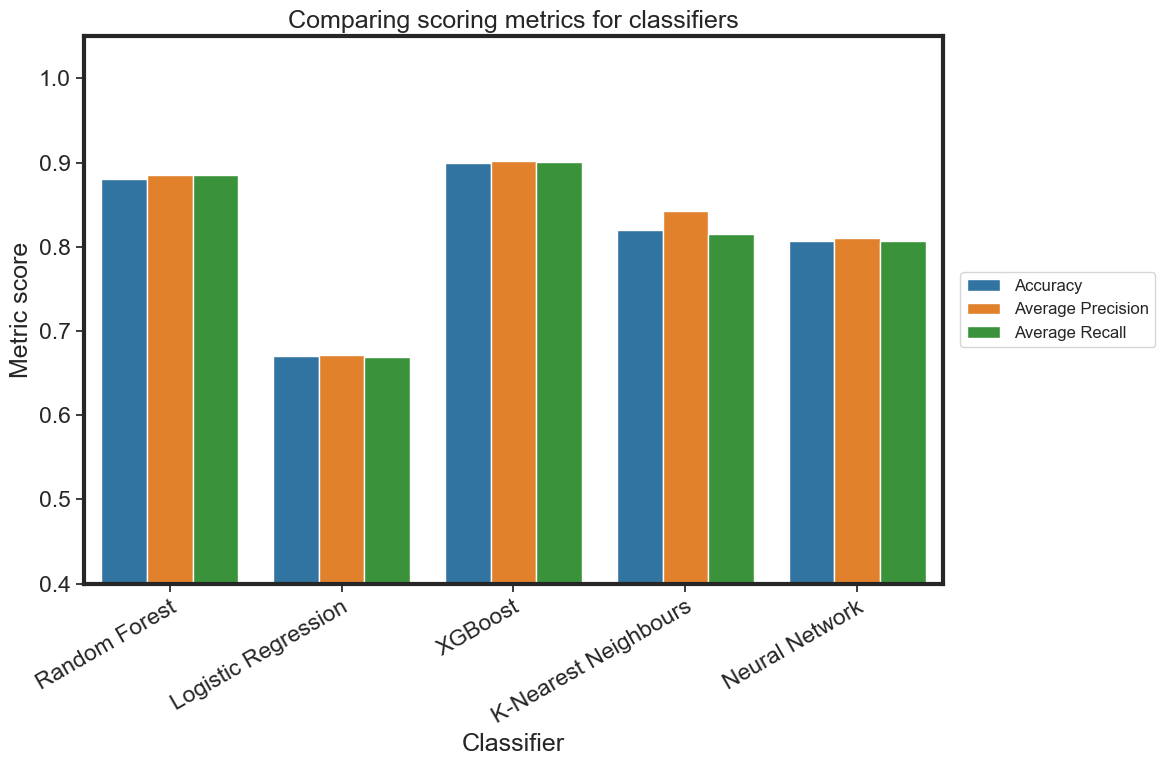

In [59]:
all_recall_acc_scores = {
    'Classifier':['Random Forest', 'Logistic Regression','XGBoost','K-Nearest Neighbours','Neural Network'],
    'Accuracy':[0.88,0.67,0.90,0.82,0.806607574536664],
    "Average Precision":[randfor_avg_precision_score,logistic_avg_precision_score, xgboost_avg_precision_score, knn_avg_precision_score, nn_avg_precision],
    'Average Recall':[randfor_avg_recall_score,logistic_avg_recall_score, xgboost_avg_recall_score, knn_avg_recall_score, nn_avg_recall],
}

all_recall_acc_scores = pd.DataFrame(data=all_recall_acc_scores)
all_recall_acc_scores = pd.melt(all_recall_acc_scores, id_vars='Classifier')
all_recall_acc_scores.rename(columns={'variable':'Metric'}, inplace=True)

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("ticks"):
    fig, axs = plt.subplots(figsize=(12,8))
    sns.barplot(data=all_recall_acc_scores, x='Classifier', y='value', hue='Metric', ax=axs)
    axs.set_xticklabels(axs.get_xticklabels(), rotation=30, horizontalalignment='right', rotation_mode='anchor')
    axs.set_ylabel('Metric score')
    axs.set_title('Comparing scoring metrics for classifiers')
    axs.set_ylim(0.40, 1.05)
    # Style it baby!
    for spine in ['left', 'top', 'right', 'bottom']:
        axs.spines[spine].set_linewidth(3),
    plt.legend(bbox_to_anchor=[1.01, 0.5], loc='center left')
    # Nothing but the classics
    plt.tight_layout()
    plt.show()

UCI Dataset

In [65]:
import zipfile
import os

# Define file path
zip_path = "../raw_data/UCI/heart+disease.zip"
extract_path = "../raw_data/UCI/heart_disease"

# Extract ZIP contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)


['ask-detrano',
 'bak',
 'cleve.mod',
 'cleveland.data',
 'costs',
 'heart-disease.names',
 'hungarian.data',
 'Index',
 'long-beach-va.data',
 'new.data',
 'processed.cleveland.data',
 'processed.hungarian.data',
 'processed.switzerland.data',
 'processed.va.data',
 'reprocessed.hungarian.data',
 'switzerland.data',
 'WARNING']

In [66]:
import pandas as pd

# Define column names (based on UCI documentation)
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang",
    "oldpeak", "slope", "ca", "thal", "num"
]

# File paths for each dataset
'''file_paths = {
    "cleveland": f"{extract_path}/processed.cleveland.data",
    "hungarian": f"{extract_path}/processed.hungarian.data",
    "switzerland": f"{extract_path}/processed.switzerland.data",
    "va": f"{extract_path}/processed.va.data"
}'''

file_paths = {
    "cleveland": f"{extract_path}/processed.cleveland.data"
}
# Load all datasets into a dictionary
dfs = {}

for name, path in file_paths.items():
    try:
        df = pd.read_csv(path, names=columns, na_values="?")
        df["source"] = name  
        dfs[name] = df
    except Exception as e:
        print(f"Error loading {name}: {e}")

# Combine all datasets into one
full_df = pd.concat(dfs.values(), ignore_index=True)

# Check dataset info
full_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
 14  source    303 non-null    object 
dtypes: float64(13), int64(1), object(1)
memory usage: 35.6+ KB


In [67]:
full_df.shape

(303, 15)

In [68]:
full_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,source
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,cleveland
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,cleveland
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,cleveland
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,cleveland
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,cleveland


In [69]:
full_df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
source      0
dtype: int64

In [70]:
full_df = full_df.dropna()

In [71]:
full_df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
source      0
dtype: int64

In [72]:
full_df.duplicated().sum()

np.int64(0)

In [73]:
full_df.drop(columns=['source'],inplace=True)

In [74]:
X=full_df.drop(columns=['num'])
y=full_df['num']

In [75]:
# Convert multi-class to binary (0 = No Disease, 1+ = Disease)
y_binary = y.apply(lambda x: 1 if x > 0 else 0)



# Check class distribution before
num_before = dict(Counter(y_binary))

# Define Pipeline
over = SMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')
steps = [("o", over), ("u", under)]
pipeline = Pipeline(steps=steps)


X_smote, y_smote = pipeline.fit_resample(X, y_binary)


num_after = dict(Counter(y_smote))
print("Before SMOTE:", num_before)
print("After SMOTE:", num_after)


Before SMOTE: {0: 160, 1: 137}
After SMOTE: {0: 160, 1: 160}


In [76]:
print(num_before,num_after)

{0: 160, 1: 137} {0: 160, 1: 160}


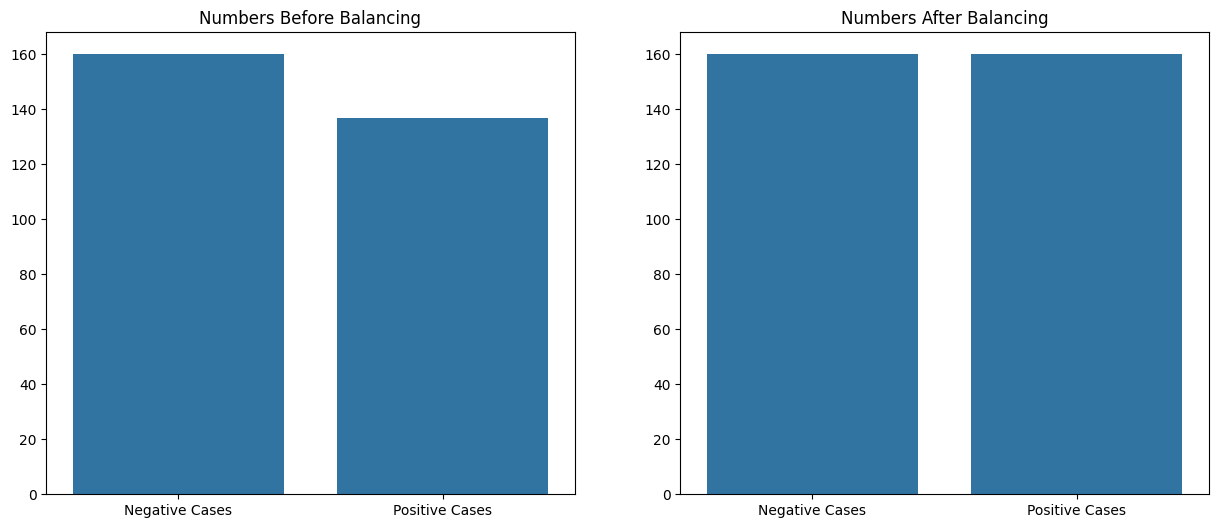

In [77]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x=labels, y=list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(x=labels, y=list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

In [78]:
new_data = pd.concat([pd.DataFrame(X_smote), pd.DataFrame(y_smote)], axis=1)
new_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0


In [79]:
X_new = new_data.iloc[:, 0:14]
y_new= new_data.iloc[:,-1]
X_new.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0
7,57.0,0.0,4.0,120.0,354.0,0.0,0.0,163.0,1.0,0.6,1.0,0.0,3.0,0


In [80]:
X_train,X_test,y_train,y_test=train_test_split(X_smote,y_smote,test_size=0.2,random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(256, 13)
(256,)
(64, 13)
(64,)


In [81]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [82]:
X_train=pd.DataFrame(X_train_scaled,columns=columns[:-1])
X_test=pd.DataFrame(X_test_scaled,columns=columns[:-1])

In [83]:
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,-1.522090,-1.346398,-1.248492,-0.330056,1.243479,-0.405026,-0.989571,0.636387,-0.748439,-0.947707,-1.014938,-0.765182,-0.890463
1,0.794470,0.750297,0.864128,-0.328639,1.768688,1.924292,0.640687,-0.622474,1.360205,0.883140,-0.683589,2.084657,1.188192
2,0.845148,-1.070735,-0.053304,-0.182844,0.292917,-0.405026,-0.722080,-2.252823,-0.471204,0.248167,0.871824,0.329821,0.914900
3,0.370547,0.750297,-1.248492,-0.658992,0.781175,-0.405026,1.044964,0.505320,-0.748439,0.668975,0.652586,-0.765182,-0.890463
4,1.038537,0.750297,-0.192182,0.437460,1.852880,-0.405026,-0.989571,0.417943,-0.748439,-0.947707,-1.014938,-0.765182,-0.890463


Random Forest

In [84]:
param_grid = {
    'n_estimators': [25, 30, 40, 50, 75, 100, 150, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [8, 9, 10, 11, 12],
    'criterion' :['gini', 'entropy']
}
randfor = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5)
randfor.fit(X_train, y_train)

print(randfor.best_params_)


{'criterion': 'gini', 'max_depth': 11, 'max_features': 'sqrt', 'n_estimators': 40}


              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.79      0.84      0.82        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64



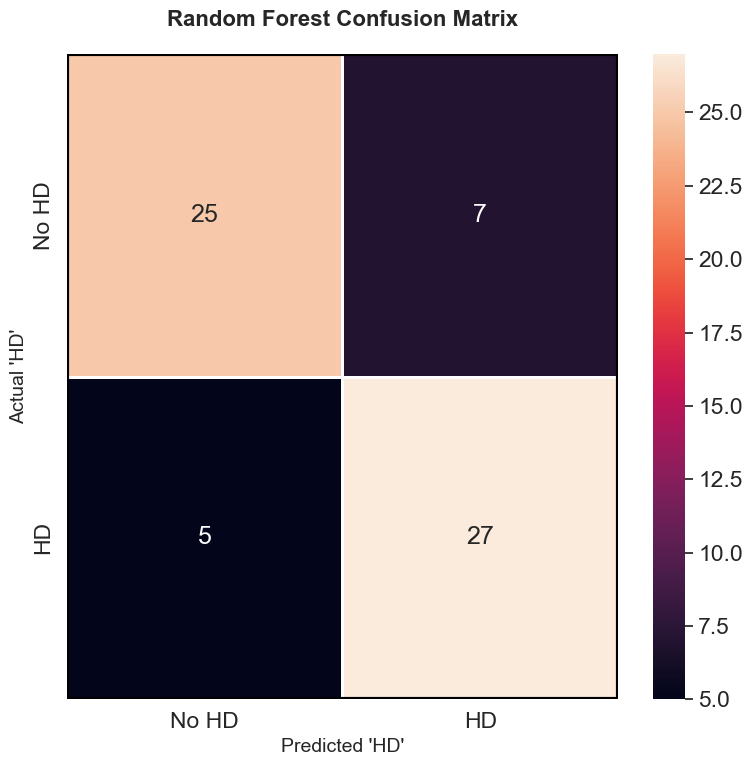

In [85]:
y_pred_randfor = randfor.predict(X_test)

print(classification_report(y_test, y_pred_randfor))

confusion_randfor = confusion_matrix(y_test, y_pred_randfor)

with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))

    class_labels = ["No HD", "HD"]
    sns.heatmap(confusion_randfor, annot=True, fmt="d", cmap='rocket', linewidths=2, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('Random Forest Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted 'HD'", fontsize=14)
    ax.set_ylabel("Actual 'HD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=confusion_randfor.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=confusion_randfor.shape[1], color='black', linewidth=3)

    # Improve layout
    plt.tight_layout()
    plt.show()


In [86]:
randfor_recall_score = recall_score(y_test, y_pred_randfor, labels=[1])
randfor_avg_recall_score = recall_score(y_test, y_pred_randfor, average="weighted")
randfor_avg_precision_score = precision_score(y_test, y_pred_randfor, average="weighted")
print(f"Random Forest Classifier Recall ('Average'): {randfor_avg_recall_score}")
print(f"Random Forest Classifier Precision ('Average'): {randfor_avg_precision_score}")

Random Forest Classifier Recall ('Average'): 0.8125
Random Forest Classifier Precision ('Average'): 0.8137254901960784


Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


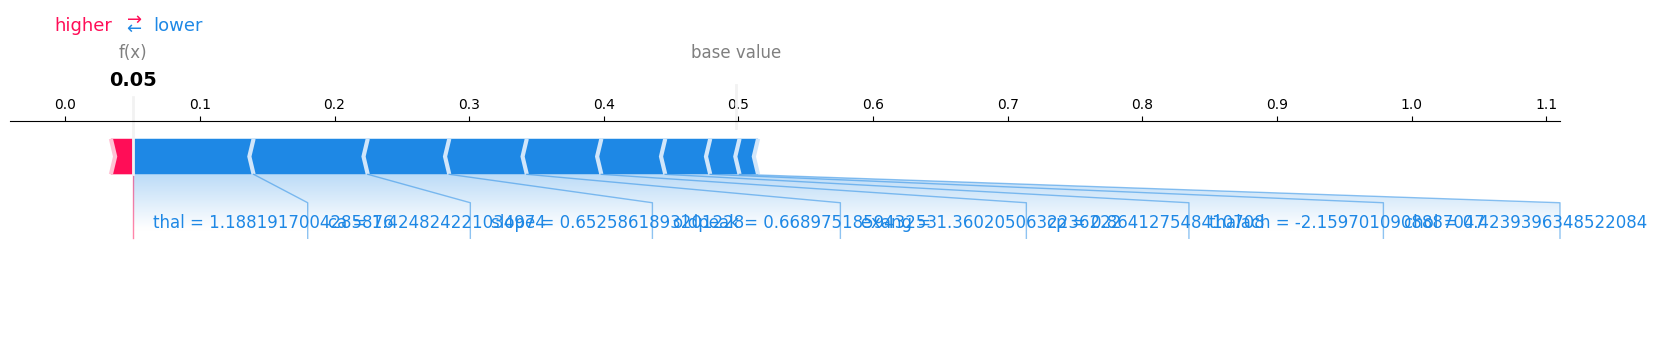

In [87]:
import shap

shap.initjs()
explainer_randfor = shap.KernelExplainer(randfor.best_estimator_.predict_proba, X_train)

shap_values = explainer_randfor.shap_values(X_test.iloc[0,:])
shap.plots.force(explainer_randfor.expected_value[0], shap_values[..., 0], X_test.iloc[0,:],matplotlib=True)

Logistic Regression

In [88]:
param_grid={
    'C':[0.001,0.01,0.1,1,10,100,1000],
    'penalty':['l1','l2'],
    'solver':['liblinear']
}
logistic_regression = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
logistic_regression.fit(X_train, y_train)

print(logistic_regression.best_params_)

{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.79      0.84      0.82        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64



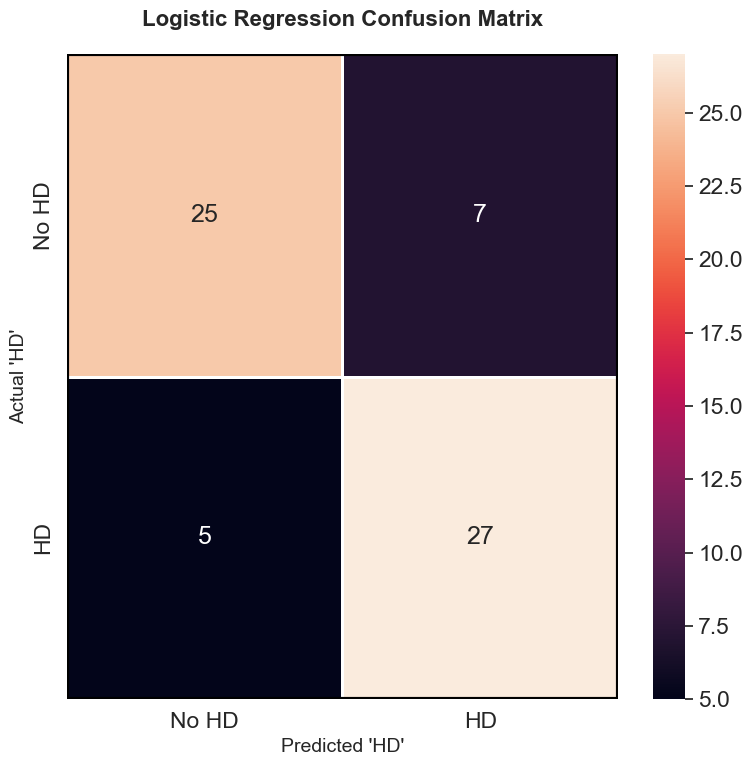

In [89]:
y_pred_logistic =logistic_regression.predict(X_test)

print(classification_report(y_test, y_pred_logistic))

confusion_logistic = confusion_matrix(y_test, y_pred_logistic)

with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))

    class_labels = ["No HD", "HD"]
    sns.heatmap(confusion_logistic, annot=True, fmt="d", cmap='rocket', linewidths=2, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('Logistic Regression Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted 'HD'", fontsize=14)
    ax.set_ylabel("Actual 'HD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=confusion_logistic.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=confusion_logistic.shape[1], color='black', linewidth=3)

    # Improve layout
    plt.tight_layout()
    plt.show()

In [92]:
logistic_recall_score = recall_score(y_test, y_pred_logistic, labels=[1])
logistic_avg_recall_score = recall_score(y_test, y_pred_logistic, average="weighted")
logistic_avg_precision_score = precision_score(y_test, y_pred_logistic, average="weighted")
print(f"Logistic Regression Recall ('Average'): {logistic_avg_recall_score}")
print(f"Logistic Regression Precision ('Average'): {logistic_avg_precision_score}")

Logistic Regression Recall ('Average'): 0.8125
Logistic Regression Precision ('Average'): 0.8137254901960784


Using 256 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


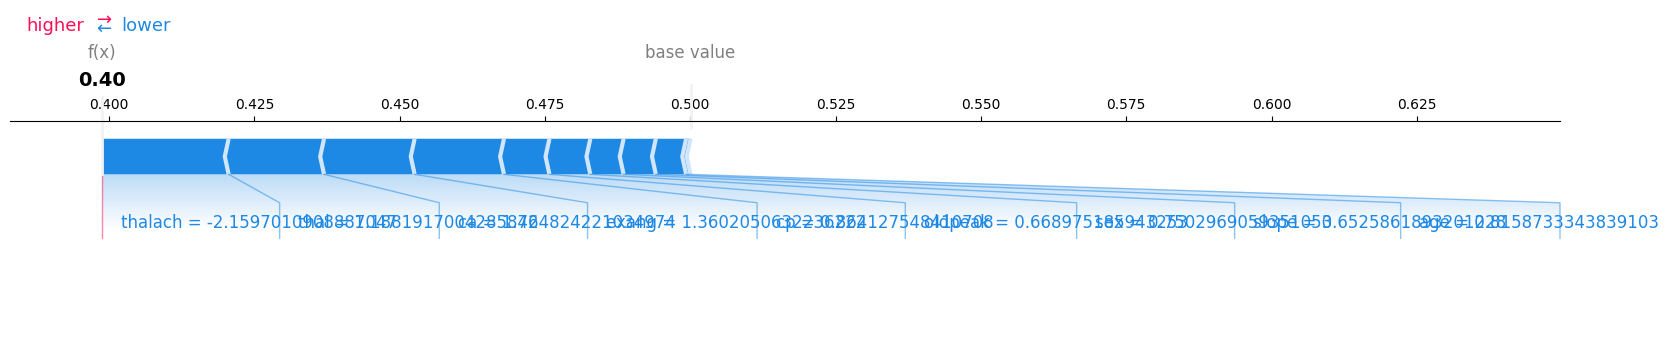

In [91]:
import shap

shap.initjs()
explainer_logistic = shap.KernelExplainer(logistic_regression.best_estimator_.predict_proba, X_train)

shap_values = explainer_logistic.shap_values(X_test.iloc[0,:])
shap.plots.force(explainer_logistic.expected_value[0], shap_values[..., 0], X_test.iloc[0,:],matplotlib=True)

XGBoost

In [93]:
param_grid={
    'n_estimators':[50,100,200],
    'learning_rate':[0.01,0.1,0.2],
    'max_depth':[3,4,5,7],
    'min_child_weight':[1,3,5],
    'subsample':[0.5,0.7,0.8,1.0],
    'colsample_bytree':[0.5,0.7,0.8,1.0]
}
xgboost = GridSearchCV(xgb.XGBClassifier(n_estimators=100, objective='binary:logistic', random_state=42), param_grid, cv=5)
xgboost.fit(X_train, y_train)
print(xgboost.best_params_)

{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.5}


              precision    recall  f1-score   support

           0       0.83      0.78      0.81        32
           1       0.79      0.84      0.82        32

    accuracy                           0.81        64
   macro avg       0.81      0.81      0.81        64
weighted avg       0.81      0.81      0.81        64



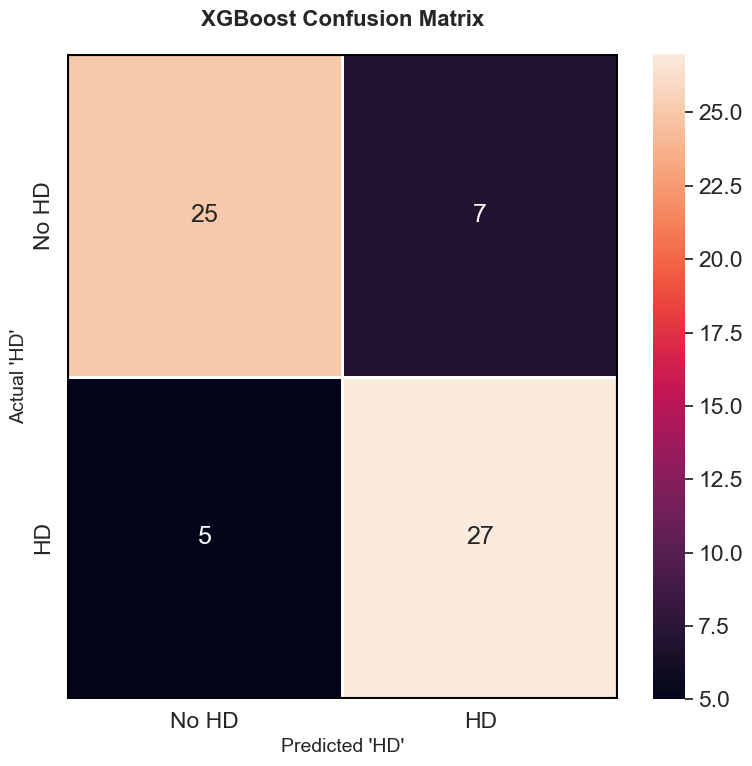

In [98]:
y_pred_xgboost =xgboost.predict(X_test)

print(classification_report(y_test, y_pred_xgboost))

confusion_xgboost = confusion_matrix(y_test, y_pred_xgboost)

with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))

    class_labels = ["No HD", "HD"]
    sns.heatmap(confusion_xgboost, annot=True, fmt="d", cmap='rocket', linewidths=2, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('XGBoost Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted 'HD'", fontsize=14)
    ax.set_ylabel("Actual 'HD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=confusion_xgboost.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=confusion_xgboost.shape[1], color='black', linewidth=3)

    # Improve layout
    plt.tight_layout()
    plt.show()

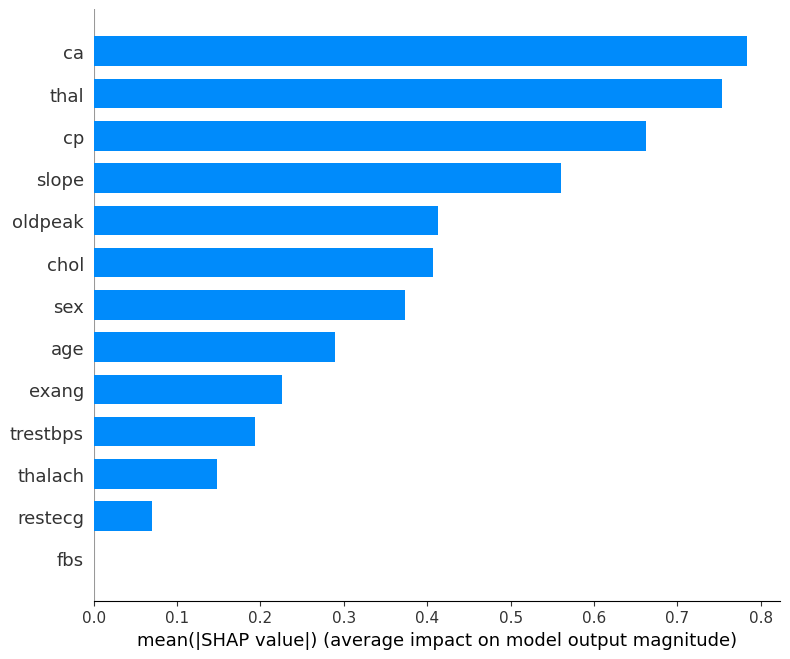

In [95]:
import shap

explainer = shap.TreeExplainer(xgboost.best_estimator_)
shap_values = explainer.shap_values(X_test)

# Summary plot with readable names
shap.summary_plot(shap_values, X_test, plot_type="bar")




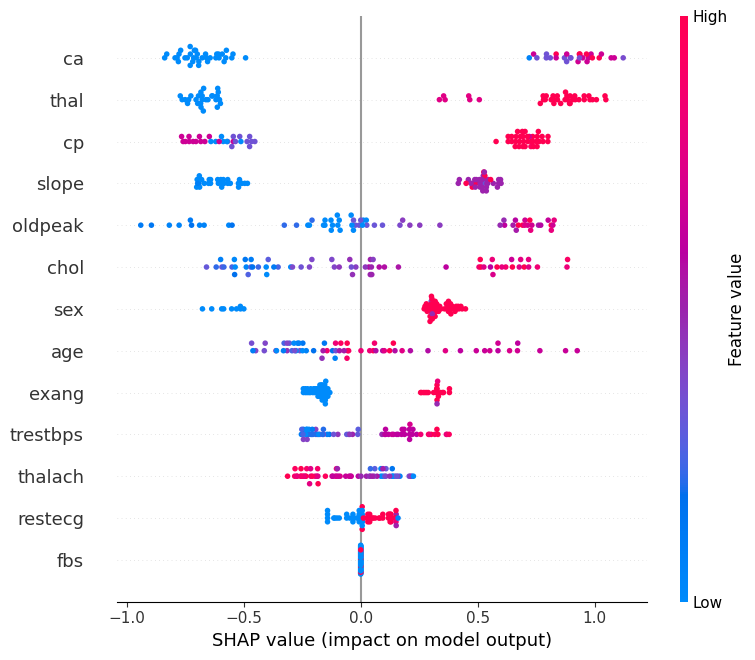

In [96]:
shap.summary_plot(shap_values, X_test)

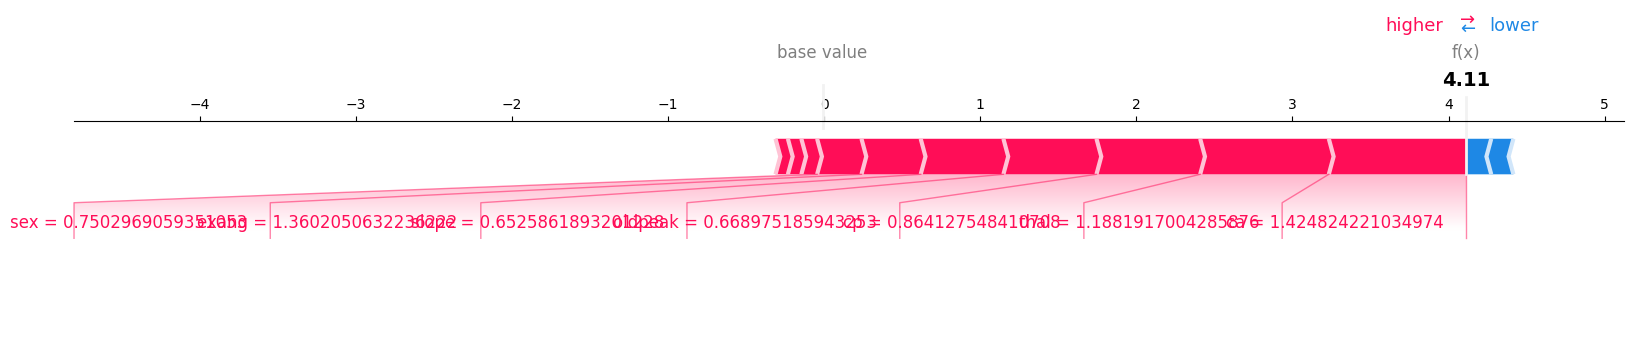

In [97]:
# Create a SHAP explainer for the model
explainer = shap.Explainer(xgboost.best_estimator_)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# If SHAP values are an Explanation object, extract the values
if isinstance(shap_values, shap.Explanation):
    shap_values = shap_values.values

shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :], matplotlib=True)


In [99]:
xgboost_recall_score = recall_score(y_test, y_pred_xgboost, labels=[1])
xgboost_avg_recall_score = recall_score(y_test, y_pred_xgboost, average="weighted")
xgboost_avg_precision_score = precision_score(y_test, y_pred_xgboost, average="weighted")
print(f"XGBoost Recall ('Average'): {xgboost_avg_recall_score}")
print(f"XGBoost Precision ('Average'): {xgboost_avg_precision_score}")

XGBoost Recall ('Average'): 0.8125
XGBoost Precision ('Average'): 0.8137254901960784


KNN

In [100]:
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],  # Number of nearest neighbors
    'weights': ['uniform', 'distance'],  # Weighting strategy
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Initialize and train KNN with GridSearchCV
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5)
knn_grid.fit(X_train, y_train)

# Best parameters
print("Best KNN Parameters:", knn_grid.best_params_)

Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}


              precision    recall  f1-score   support

           0       0.89      0.78      0.83        32
           1       0.81      0.91      0.85        32

    accuracy                           0.84        64
   macro avg       0.85      0.84      0.84        64
weighted avg       0.85      0.84      0.84        64



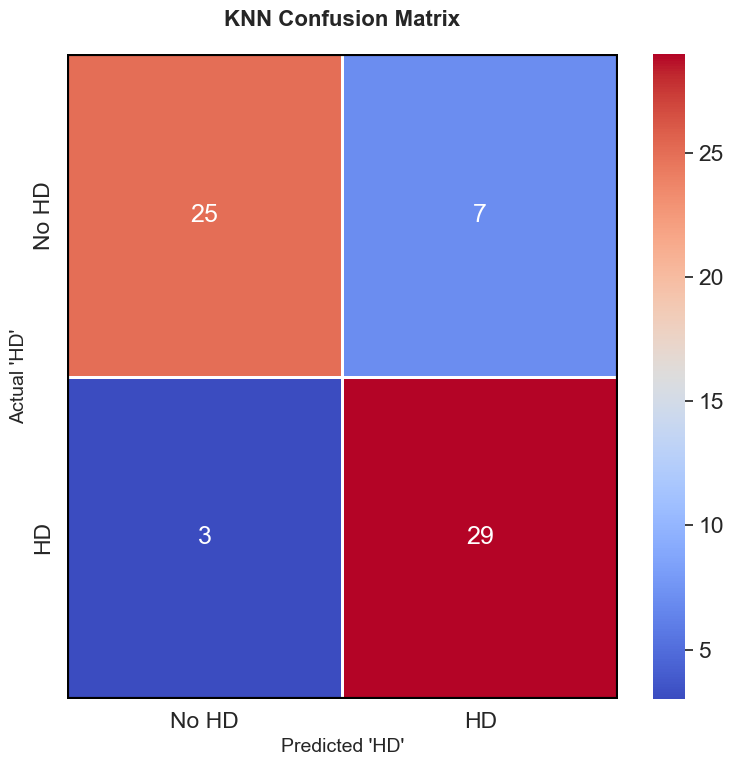

In [101]:
y_pred_knn =knn_grid.predict(X_test)

print(classification_report(y_test, y_pred_knn))

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)


# Confusion Matrix Visualization
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
with sns.plotting_context("notebook", font_scale=1.5), sns.axes_style("white"):
    fig, ax = plt.subplots(figsize=(8,8))
    class_labels = ["No HD", "HD"]
    sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap='coolwarm', linewidths=2,
                xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_title('KNN Confusion Matrix', fontsize=16, weight='bold', pad=20)
    ax.set_xlabel("Predicted 'HD'", fontsize=14)
    ax.set_ylabel("Actual 'HD'", fontsize=14)
    ax.axhline(y=0, color='black', linewidth=3)
    ax.axhline(y=conf_matrix_knn.shape[0], color='black', linewidth=3)
    ax.axvline(x=0, color='black', linewidth=3)
    ax.axvline(x=conf_matrix_knn.shape[1], color='black', linewidth=3)
    plt.tight_layout()
    plt.show()

In [102]:
knn_recall_score = recall_score(y_test, y_pred_knn, labels=[1])
knn_avg_recall_score = recall_score(y_test, y_pred_knn, average="weighted")
knn_avg_precision_score = precision_score(y_test, y_pred_knn, average="weighted")
print(f"KNN Recall ('Average'): {knn_avg_recall_score}")
print(f"KNN Precision ('Average'): {knn_avg_precision_score}")

KNN Recall ('Average'): 0.84375
KNN Precision ('Average'): 0.8492063492063493


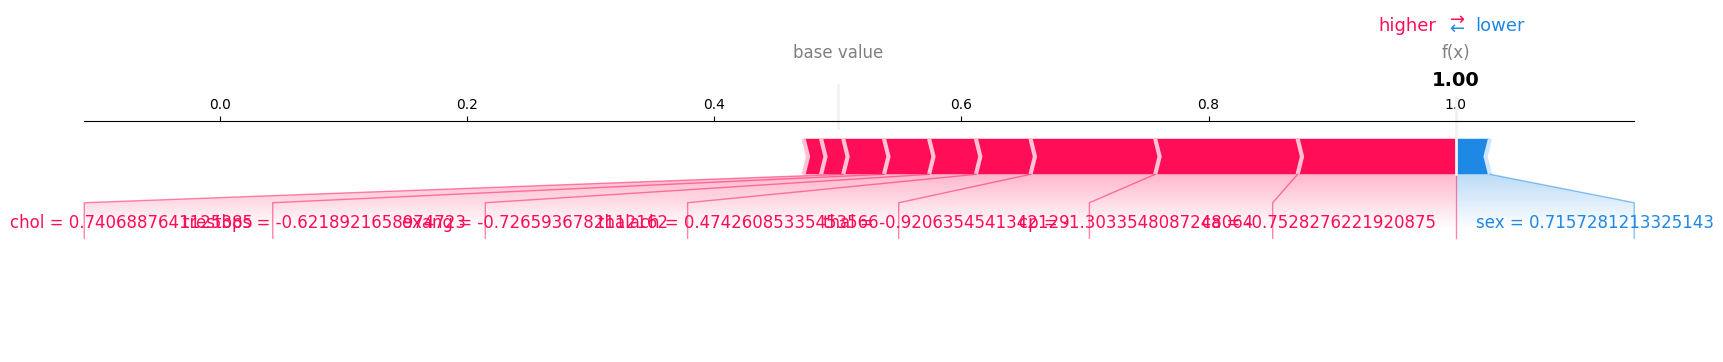

In [ ]:
import shap

shap.initjs()
explainer_knn = shap.KernelExplainer(knn_grid.best_estimator_.predict_proba, X_train)

shap_values = explainer_knn.shap_values(X_test.iloc[0,:])
shap.plots.force(explainer_knn.expected_value[0], shap_values[..., 0], X_test.iloc[0,:],matplotlib=True)

Neural Network

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

In [104]:
class NeuralNetwork(nn.Module):
    def __init__(self,input_size):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [105]:
model = NeuralNetwork(X_train.shape[1]).to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [106]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 300
batch_size = 16
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [10/300], Loss: 0.5701
Epoch [20/300], Loss: 0.4448
Epoch [30/300], Loss: 0.3621
Epoch [40/300], Loss: 0.3271
Epoch [50/300], Loss: 0.3031
Epoch [60/300], Loss: 0.2806
Epoch [70/300], Loss: 0.2589
Epoch [80/300], Loss: 0.2368
Epoch [90/300], Loss: 0.2141
Epoch [100/300], Loss: 0.1913
Epoch [110/300], Loss: 0.1678
Epoch [120/300], Loss: 0.1437
Epoch [130/300], Loss: 0.1203
Epoch [140/300], Loss: 0.0983
Epoch [150/300], Loss: 0.0785
Epoch [160/300], Loss: 0.0616
Epoch [170/300], Loss: 0.0479
Epoch [180/300], Loss: 0.0373
Epoch [190/300], Loss: 0.0292
Epoch [200/300], Loss: 0.0232
Epoch [210/300], Loss: 0.0187
Epoch [220/300], Loss: 0.0152
Epoch [230/300], Loss: 0.0126
Epoch [240/300], Loss: 0.0106
Epoch [250/300], Loss: 0.0090
Epoch [260/300], Loss: 0.0078
Epoch [270/300], Loss: 0.0068
Epoch [280/300], Loss: 0.0059
Epoch [290/300], Loss: 0.0053
Epoch [300/300], Loss: 0.0047


In [107]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = (y_pred_test > 0.5).float()  # Convert probabilities to binary values (0 or 1)

# Convert predictions to numpy for evaluation
y_pred_np = y_pred_labels.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

# Calculate accuracy
accuracy = accuracy_score(y_test_np, y_pred_np)
print("Test Set Accuracy:", accuracy)

nn_precision = precision_score(y_test_np, y_pred_np)
print("Test Set Precision:", nn_precision)

# Calculate recall
nn_recall = recall_score(y_test_np, y_pred_np)
print("Test Set Recall:", nn_recall)

nn_avg_precision = precision_score(y_test_np, y_pred_np, average="weighted")

# Calculate recall
nn_avg_recall = recall_score(y_test_np, y_pred_np, average="weighted")

Test Set Accuracy: 0.734375
Test Set Precision: 0.6923076923076923
Test Set Recall: 0.84375


C:\Users\Shreyas Raman\AppData\Local\Temp\ipykernel_41976\452436618.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs.set_xticklabels(axs.get_xticklabels(), rotation=30, horizontalalignment='right', rotation_mode='anchor')


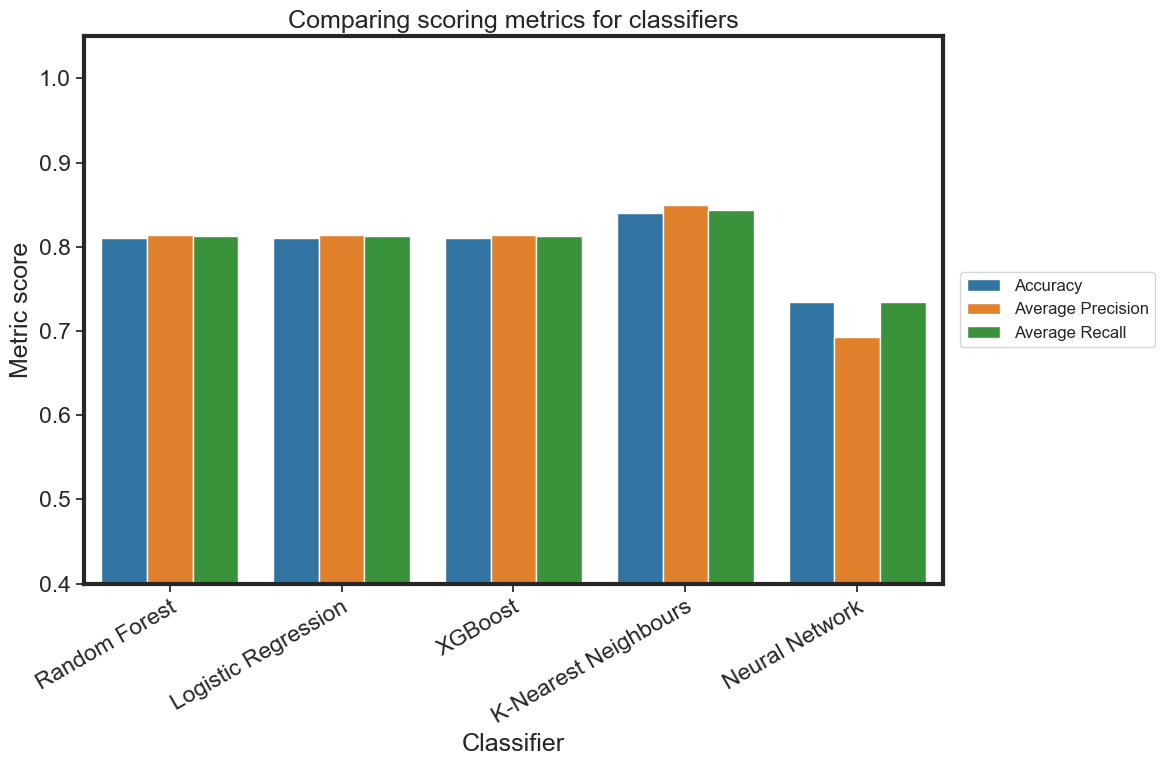

In [108]:

all_recall_acc_scores = {
    'Classifier':['Random Forest', 'Logistic Regression','XGBoost','K-Nearest Neighbours','Neural Network'],
    'Accuracy':[0.81 , 0.81,  0.81 , 0.84,  0.734375],
    'Average Precision':[randfor_avg_precision_score,logistic_avg_precision_score, xgboost_avg_precision_score, knn_avg_precision_score, nn_precision],
    'Average Recall':[randfor_avg_recall_score,logistic_avg_recall_score, xgboost_avg_recall_score, knn_avg_recall_score, nn_avg_recall],
}

all_recall_acc_scores = pd.DataFrame(data=all_recall_acc_scores)
all_recall_acc_scores = pd.melt(all_recall_acc_scores, id_vars='Classifier')
all_recall_acc_scores.rename(columns={'variable':'Metric'}, inplace=True)

with sns.plotting_context("notebook", font_scale=1.5, rc={"legend.fontsize":12, "legend.title_fontsize":14}), sns.axes_style("ticks"):
    fig, axs = plt.subplots(figsize=(12,8))
    sns.barplot(data=all_recall_acc_scores, x='Classifier', y='value', hue='Metric', ax=axs)
    axs.set_xticklabels(axs.get_xticklabels(), rotation=30, horizontalalignment='right', rotation_mode='anchor')
    axs.set_ylabel('Metric score')
    axs.set_title('Comparing scoring metrics for classifiers')
    axs.set_ylim(0.40, 1.05)
    # Style it baby!
    for spine in ['left', 'top', 'right', 'bottom']:
        axs.spines[spine].set_linewidth(3),
    plt.legend(bbox_to_anchor=[1.01, 0.5], loc='center left')
    # Nothing but the classics
    plt.tight_layout()
    plt.show()
